<a href="https://colab.research.google.com/github/hrllscrt/esda/blob/main/Image_segmentation_Landsat8_OLI_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title # Setup
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
!ln -s /content/gdrive/My\ Drive/misc_data/unet_datasets /content/datasets

In [3]:
!ls /content/datasets

images	labels	unet_datasets


In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 10
!pip install rasterio

Autosaving every 10 seconds
     |████████████████████████████████| 19.1MB 1.4MB/s 


In [ ]:
#@title **Install Packages**
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install gdal-bin
!export CPLUS_INCLUDE_PATH=/usr/include/gdal
!export C_INCLUDE_PATH=/usr/include/gdal
!pip install GDAL
!export GDAL_DATA=/usr/share/gdal

!pip install rasterio==1.2.1 shapely==1.7.1 geopandas

In [6]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.vision.learner import cnn_config

from torch.utils.data import Dataset
import torch.nn as nn

import matplotlib.pyplot as plt


In [7]:
import fastai
print(fastai.__version__)

1.0.61


In [11]:
path = Path('/content/datasets')
path_lbl = path/'labels'
path_img = path/'images'

In [12]:
path_lbl

PosixPath('/content/datasets/labels')

## Data

In [13]:
# Check the training image chips
fnames = get_image_files(path_img)
fnames[:1]

[PosixPath('/content/datasets/images/LC08_L2SP_120059_20150630_15.tif')]

In [14]:
# Check the training labeled masks
lbl_names = get_image_files(path_lbl)
lbl_names[:1]

[PosixPath('/content/datasets/labels/LC08_L2SP_120059_20190116_12.png')]

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


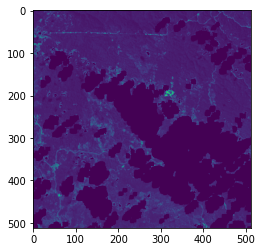

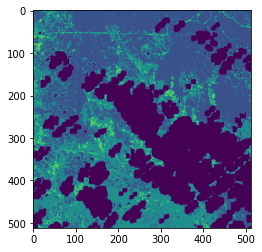

In [15]:
# import libraries for viewing spatial data
from osgeo import gdal
import rasterio as rio
from rasterio.plot import show

# assigning a the total number of images in path_img (indexes) and randomizing 
## it in numpy list form 
n = np.random.choice(len(fnames))

# using rasterio to open one of the images as src
with rio.open(fnames[n]) as src:
    arr = src.read(1) # read src raster and calls the first index that contains the info on number of band
    crs = src.crs # read the coordinate system of the raster
    transform0 = src.transform # provide method to calculate based on rows, columns and coordinates of raster array
    driver0 = src.driver # read drivers or formats for GDAL data

get_y_fn = lambda x: path_lbl/f'{x.stem}.png' # something to do with labeling the data?

with rio.open(get_y_fn(fnames[n])) as src:
    lbl_arr = src.read(1)
    profile1 = src.profile
    profile1.update(
        driver = driver0,
        crs = crs,
        transform=transform0,
        )
    
show(arr) ; show(lbl_arr)

In [ ]:
img_f = fnames[n]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

In [ ]:
img = open_image(get_y_fn(img_f))
img.show(figsize=(5,5))

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])

print(src_size)

mask.data

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

## Datasets

In [ ]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
if free > 8200: 
  bs=2
else:
  bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(3, figsize=(10, 7))

In [ ]:
data.show_batch(3, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Void']

def acc_landuse(input, target):
    target = target.squeeze(1)
    mask = target # != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
name2id

In [ ]:
metrics = acc_landuse

In [ ]:
wd = 1e-2

In [ ]:
# def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
#                  norm_type:Optional[NormType]=NormType, split_on=None, blur:bool=False,
#                  self_attention:bool=False, y_range=None, last_cross:bool=True,
#                  bottle:bool=False, cut=None, **learn_kwargs:Any)->Learner:
#     "Build Unet learner from `data` and `arch`."
    
#     # I have defined size intentionally like this, so that it won't be a problem when 
#     # the input is an image 
#     size = next(iter(data.train_dl))[0].shape[-2:]
#     n_input_channels = next(iter(data.train_dl))[0][0].size(0)    
        
#     meta = cnn_config(arch)
#     body = create_body(arch, pretrained, cut)
    
#     # changing the first layer to suit our input
#     if not n_input_channels == 3: 
#         prev_layer = body[0]
#         body[0] = nn.Conv2d(n_input_channels, prev_layer.out_channels, 
#                       kernel_size=prev_layer.kernel_size, 
#                       stride=prev_layer.stride, 
#                       padding=prev_layer.padding, 
#                       bias=prev_layer.bias)

#     model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
#           self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
#           bottle=bottle), data.device)
#     learn = Learner(data, model, **learn_kwargs)
#     learn.split(ifnone(split_on, meta['split']))
#     if pretrained and n_input_channels == 3: 
#         learn.freeze()
#         apply_init(model[2], nn.init.kaiming_normal_)
#     else: apply_init(model, nn.init.kaiming_normal_)
#     return learn

In [ ]:
# create unet
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
print(learn)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.show_results(rows=3, figsize=(8, 9))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))

In [ ]:
learn.save('stage-2')

In [ ]:
!ls -la /root/.fastai/data/camvid/

## Train on bigger images

In [ ]:
learn.destroy()

size = src_size # // 1.5

free = gpu_mem_get_free_no_cache()
if free > 8200: 
  bs=3
else: 
  bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
# def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
#                  norm_type:Optional[NormType]=NormType, split_on=None, blur:bool=False,
#                  self_attention:bool=False, y_range=None, last_cross:bool=True,
#                  bottle:bool=False, cut=None, **learn_kwargs:Any)->Learner:
#     "Build Unet learner from `data` and `arch`."
    
#     # I have defined size intentionally like this, so that it won't be a problem when 
#     # the input is an image 
#     size = next(iter(data.train_dl))[0].shape[-2:]
#     n_input_channels = next(iter(data.train_dl))[0][0].size(0)    
        
#     meta = cnn_config(arch)
#     body = create_body(arch, pretrained, cut)
    
#     # changing the first layer to suit our input
#     if not n_input_channels == 3: 
#         prev_layer = body[0]
#         body[0] = nn.Conv2d(n_input_channels, prev_layer.out_channels, 
#                       kernel_size=prev_layer.kernel_size, 
#                       stride=prev_layer.stride, 
#                       padding=prev_layer.padding, 
#                       bias=prev_layer.bias)

#     model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
#           self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
#           bottle=bottle), data.device)
#     learn = Learner(data, model, **learn_kwargs)
#     learn.split(ifnone(split_on, meta['split']))
#     if pretrained and n_input_channels == 3: 
#         learn.freeze()
#         apply_init(model[2], nn.init.kaiming_normal_)
#     else: apply_init(model, nn.init.kaiming_normal_)
#     return learn

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('big-stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, lr/10))

In [ ]:
learn.save('stage-2-big')

## Interpretation

In [ ]:
learn.show_results(rows=2, figsize=(10, 10))